lab3-1: 간단한 VQE -- cos(t) 최솟값 찾기
  Step   0:  t=0.6918,  <Z>=0.770118
  Step  10:  t=3.0788,  <Z>=-0.998031
  Step  20:  t=3.1412,  <Z>=-1.000000
  Step  30:  t=3.1416,  <Z>=-1.000000
  Step  40:  t=3.1416,  <Z>=-1.000000
  최종:  t=3.1416  (이론 pi=3.1416),  <Z>=-1.000000


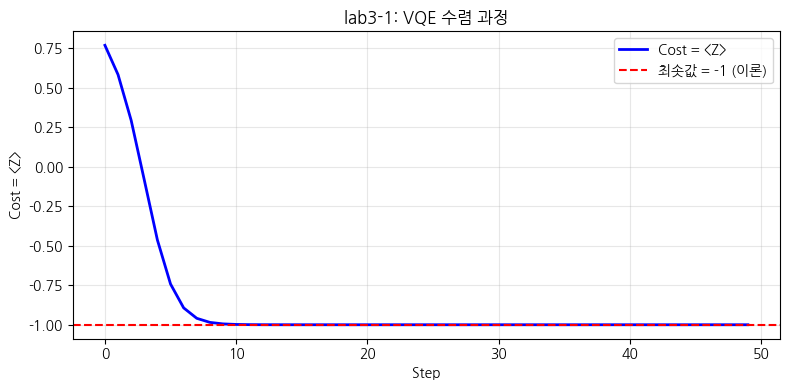


lab3-2: Bell 상태 & 얽힘
  [회로도]
0: ──H─╭●─┤ ╭Probs
1: ────╰X─┤ ╰Probs

  확률 분포:
    |00>  P = 0.5000
    |01>  P = 0.0000
    |10>  P = 0.0000
    |11>  P = 0.5000

  <Z0>     = 0.0000  (이론: 0)
  <Z1>     = 0.0000  (이론: 0)
  <Z0 Z1>  = 1.0000  (이론: 1 -> 완전 상관)
  상관관계  = 1.0000

  [shots=1024] 측정 횟수: {'00': 509, '01': 0, '10': 0, '11': 515}
  |00>과 |11>만 관측 -- 얽힘 상태의 핵심 특징
  정확히 50:50이 아닌 이유: 유한 샘플링에 의한 통계 변동


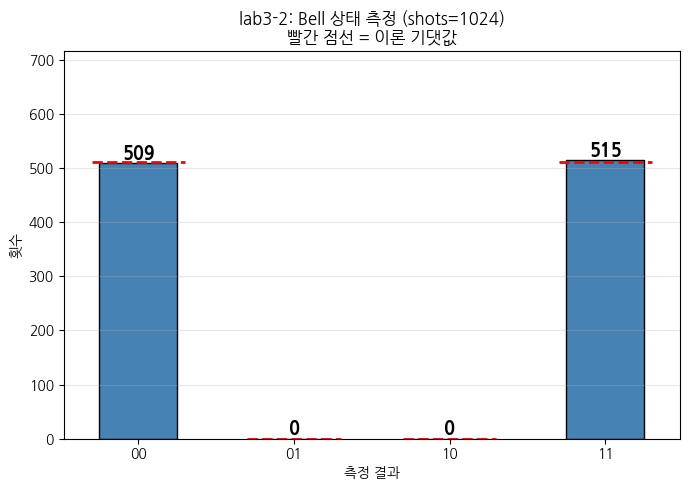


lab3 완료!


In [2]:
# !pip install pennylane koreanize_matplotlib -q
import pennylane as qml
from pennylane import numpy as np
import numpy as std_np
import matplotlib.pyplot as plt
import koreanize_matplotlib
plt.rcParams['axes.unicode_minus'] = False

# ============================================================
# ===== 학생 수정 영역 =====
shots = 1024
# 추천: 100 -> 흔들림 큼 / 1024 -> 기본값 / 10000 -> 이론에 수렴
# ===== 수정 끝 =====
# ============================================================

# ===========================================================
#  3-1: VQE 최적화
# ===========================================================

print("=" * 60)
print("lab3-1: 간단한 VQE -- cos(t) 최솟값 찾기")
print("=" * 60)

dev1 = qml.device("default.qubit", wires=1)

@qml.qnode(dev1)
def vqe_cost(params):
    qml.RX(params[0], wires=0)
    return qml.expval(qml.PauliZ(0))

opt     = qml.GradientDescentOptimizer(stepsize=0.4)
params  = np.array([0.5], requires_grad=True)
history = []

for step in range(50):
    params = opt.step(vqe_cost, params)
    cost   = float(vqe_cost(params))
    history.append(cost)
    if step % 10 == 0:
        print(f"  Step {step:3d}:  t={float(params[0]):.4f},  <Z>={cost:.6f}")

print(f"  최종:  t={float(params[0]):.4f}  (이론 pi={np.pi:.4f}),  <Z>={cost:.6f}")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(history, 'b-', lw=2, label='Cost = <Z>')
ax.axhline(y=-1, color='r', ls='--', lw=1.5, label='최솟값 = -1 (이론)')
ax.set_xlabel("Step")
ax.set_ylabel("Cost = <Z>")
ax.set_title("lab3-1: VQE 수렴 과정")
ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# ===========================================================
#  3-2: Bell 상태 & 얽힘
# ===========================================================

print("\n" + "=" * 60)
print("lab3-2: Bell 상태 & 얽힘")
print("=" * 60)

dev2 = qml.device("default.qubit", wires=2)

@qml.qnode(dev2)
def bell_probs():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    return qml.probs(wires=[0, 1])

@qml.qnode(dev2)
def bell_corr():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    return (
        qml.expval(qml.PauliZ(0)),
        qml.expval(qml.PauliZ(1)),
        qml.expval(qml.PauliZ(0) @ qml.PauliZ(1)),
    )

@qml.qnode(dev2)
def bell_sample():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    return qml.sample(wires=[0, 1])

# 회로도 출력
print("  [회로도]")
print(qml.draw(bell_probs)())

# 이론값 확인
probs_analytic = bell_probs()
basis = ["00", "01", "10", "11"]
print(f"\n  확률 분포:")
for b, p in zip(basis, probs_analytic):
    print(f"    |{b}>  P = {p:.4f}")

z0, z1, zz = bell_corr()
print(f"\n  <Z0>     = {float(z0):.4f}  (이론: 0)")
print(f"  <Z1>     = {float(z1):.4f}  (이론: 0)")
print(f"  <Z0 Z1>  = {float(zz):.4f}  (이론: 1 -> 완전 상관)")
print(f"  상관관계  = {float(zz) - float(z0)*float(z1):.4f}")

# shots 측정
bell_sample_s = qml.set_shots(bell_sample, shots=shots)
raw = bell_sample_s()                          # shape: (shots, 2)
labels_meas = [''.join(map(str, r)) for r in raw.tolist()]
count_vals  = [labels_meas.count(b) for b in basis]

print(f"\n  [shots={shots}] 측정 횟수: {dict(zip(basis, count_vals))}")
print(f"  |00>과 |11>만 관측 -- 얽힘 상태의 핵심 특징")
print(f"  정확히 50:50이 아닌 이유: 유한 샘플링에 의한 통계 변동")

# 시각화 -- 단순 막대 + 이론선
expected = [p * shots for p in probs_analytic]
colors   = ['steelblue' if c > 0 else 'lightgray' for c in count_vals]

fig, ax = plt.subplots(figsize=(7, 5))
bars = ax.bar(basis, count_vals, color=colors, edgecolor='black', width=0.5)

# 이론값 점선
for i, exp in enumerate(expected):
    ax.plot([i - 0.3, i + 0.3], [exp, exp], 'r--', lw=2)

# 숫자 표기
for bar, val in zip(bars, count_vals):
    ax.text(bar.get_x() + bar.get_width()/2, val + 8,
            str(val), ha='center', fontsize=13, fontweight='bold')

ax.set_ylim(0, shots * 0.7)
ax.set_xlabel("측정 결과")
ax.set_ylabel("횟수")
ax.set_title(f"lab3-2: Bell 상태 측정 (shots={shots})\n빨간 점선 = 이론 기댓값")
ax.grid(axis='y', alpha=0.3)
plt.tight_layout(); plt.show()

print("\nlab3 완료!")